In [1]:
!unzip flatprices_train.csv.zip

Archive:  flatprices_train.csv.zip
  inflating: flatprices_train.csv    


In [2]:
!pip install catboost
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.0 MB/s eta 0:00:00


In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [41]:
train_data = pd.read_csv('flatprices_train.csv', sep = ';')
test_data = pd.read_csv('flatprices_test.csv', sep = ';')

In [42]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [9]:
train_df.head()

,id,number_of_rooms,floor_number,number_of_floors,exploitation_start_year,longitude,latitude,total_square,living_square,kitchen_square,source,created_at,price
0,593048,4,2,3,NaN,44.017970,56.327522,160.0,100.0,20.0,realty.ya.ru,2023-07-17 17:04:30,32000000
1,595253,2,6,9,1977.0,43.873486,56.337276,47.6,28.4,6.2,realty.ya.ru,2023-07-25 19:46:45,5000000
2,593535,2,1,5,1969.0,44.010858,56.310193,41.5,28.0,6.0,www.avito.ru,2023-07-19 22:55:01,6100000
3,581671,1,13,17,NaN,44.015661,56.266217,40.4,21.5,9.8,www.cian.ru,2023-06-07 12:22:04,4799999
4,585873,1,3,21,NaN,43.888621,56.312082,30.1,0.0,0.0,www.cian.ru,2023-06-20 17:36:55,3702200


In [10]:
test_df.head()

,id,number_of_rooms,floor_number,number_of_floors,exploitation_start_year,longitude,latitude,total_square,living_square,kitchen_square,source,created_at
0,574026,1,1,9,NaN,43.906420,56.210440,31.1,0.0,3.7,www.avito.ru,2023-04-13 13:54:18
1,589513,1,9,11,NaN,43.999060,56.297860,45.6,0.0,12.0,www.avito.ru,2023-07-03 09:58:42
2,578919,0,2,16,1929.0,43.841361,56.338669,29.3,20.5,0.0,www.cian.ru,2023-06-01 14:08:21
3,589862,2,2,5,NaN,43.897236,56.266952,42.9,25.9,5.7,www.cian.ru,2023-07-05 23:11:15
4,576247,2,5,5,1980.0,43.851000,56.305000,40.0,34.0,6.0,www.avito.ru,2023-05-30 18:07:22


In [11]:
train_df.shape

(14874, 13)

#Data preprocessing

Let`s analyze our dataset for NAN values.

In [12]:
#NaN values in train data
train_df.isna().sum()

id                            0
number_of_rooms               0
floor_number                  0
number_of_floors              0
exploitation_start_year    8325
longitude                     0
latitude                      0
total_square                  0
living_square                 0
kitchen_square                0
source                        0
created_at                    0
price                         0
dtype: int64

In [13]:
#NaN values in test data
test_df.isna().sum()

id                            0
number_of_rooms               0
floor_number                  0
number_of_floors              0
exploitation_start_year    2057
longitude                     0
latitude                      0
total_square                  0
living_square                 0
kitchen_square                0
source                        0
created_at                    0
dtype: int64

In our train and test data, The Nan values was identified, namely 8325 Nans in train data and 2057 Nans in test data, which will be replaced with 'mean'.

In [43]:
#The average numbers pf exploitation_start_year in train and test sets
avg_exp_year_train = round(train_data['exploitation_start_year'].mean())
avg_exp_year_test = round(test_data['exploitation_start_year'].mean())

In [44]:
#replacing Nan values with average number
train_data['exploitation_start_year'] = train_data['exploitation_start_year'].fillna(avg_exp_year_train)
test_data['exploitation_start_year'] = test_data['exploitation_start_year'].fillna(avg_exp_year_test)

In [16]:
train_data.head()

,id,number_of_rooms,floor_number,number_of_floors,exploitation_start_year,longitude,latitude,total_square,living_square,kitchen_square,source,created_at,price
0,593048,4,2,3,1979.0,44.017970,56.327522,160.0,100.0,20.0,realty.ya.ru,2023-07-17 17:04:30,32000000
1,595253,2,6,9,1977.0,43.873486,56.337276,47.6,28.4,6.2,realty.ya.ru,2023-07-25 19:46:45,5000000
2,593535,2,1,5,1969.0,44.010858,56.310193,41.5,28.0,6.0,www.avito.ru,2023-07-19 22:55:01,6100000
3,581671,1,13,17,1979.0,44.015661,56.266217,40.4,21.5,9.8,www.cian.ru,2023-06-07 12:22:04,4799999
4,585873,1,3,21,1979.0,43.888621,56.312082,30.1,0.0,0.0,www.cian.ru,2023-06-20 17:36:55,3702200


In [45]:
train_data['created_at'] = pd.to_datetime(train_data['created_at'], errors = 'coerce')
test_data['created_at'] = pd.to_datetime(test_data['created_at'], errors = 'coerce')

train_data['created_at'] = train_data['created_at'].astype('int64')
test_data['created_at'] = test_data['created_at'].astype('int64')

In [18]:
train_data.describe()

,id,number_of_rooms,floor_number,number_of_floors,exploitation_start_year,longitude,latitude,total_square,living_square,kitchen_square,created_at,price
count,14874.000000,14874.000000,14874.00000,14874.000000,14874.000000,14874.000000,14874.000000,14874.000000,14874.000000,14874.000000,1.487400e+04,1.487400e+04
mean,584828.452131,1.819551,6.28849,11.700417,1979.208216,43.944716,56.291066,51.976785,21.511889,8.548944,1.686902e+18,8.821638e+06
std,6871.866249,0.985734,5.08774,7.000452,14.289178,0.080338,0.040364,24.916400,18.078176,6.289847,2.457973e+15,1.194199e+08
min,573521.000000,0.000000,-2.00000,0.000000,1898.000000,43.616800,56.157439,0.000000,0.000000,0.000000,1.680318e+18,1.500000e+03
25%,578790.500000,1.000000,2.00000,5.000000,1979.000000,43.872202,56.269080,35.832500,5.525000,5.500000,1.685617e+18,4.300000e+06
50%,584554.000000,2.000000,5.00000,9.000000,1979.000000,43.948050,56.296551,46.200000,19.000000,7.700000,1.686871e+18,5.700000e+06
75%,590774.750000,2.000000,9.00000,17.000000,1979.000000,44.017420,56.318796,62.300000,31.400000,12.000000,1.688750e+18,7.930000e+06
max,597152.000000,28.000000,89.00000,28.000000,2019.000000,44.128352,56.392592,527.000000,304.000000,100.000000,1.690848e+18,9.300000e+09


In [49]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14874 entries, 0 to 14873
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       14874 non-null  int64  
 1   number_of_rooms          14874 non-null  int64  
 2   floor_number             14874 non-null  int64  
 3   number_of_floors         14874 non-null  int64  
 4   exploitation_start_year  14874 non-null  float64
 5   longitude                14874 non-null  float64
 6   latitude                 14874 non-null  float64
 7   total_square             14874 non-null  float64
 8   living_square            14874 non-null  float64
 9   kitchen_square           14874 non-null  float64
 10  source                   14874 non-null  object 
 11  created_at               14874 non-null  int64  
 12  price                    14874 non-null  int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 1.5+ MB


In [50]:
list_col = train_data.columns.to_list()
col = ['id', 'source', 'created_at']
for i in col:
  list_col.remove(i)
print(list_col)

['number_of_rooms', 'floor_number', 'number_of_floors', 'exploitation_start_year', 'longitude', 'latitude', 'total_square', 'living_square', 'kitchen_square', 'price']


Let`s visualize the outliers of features

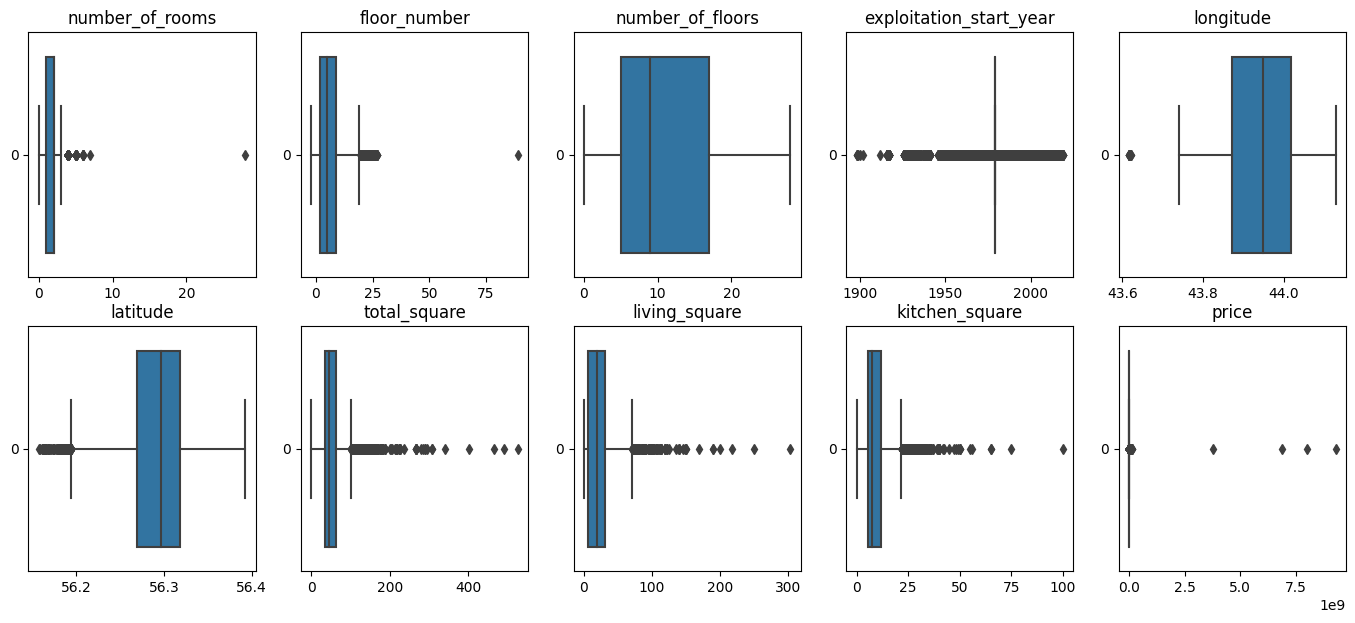

In [51]:
plt.figure(figsize = (17,7))
for i in list_col:
  plt.subplot(2, 5, list_col.index(i) + 1)
  sns.boxplot(train_data[i], orient='h').set(title=i)

We can clearly note that otliers exist in some features. Let`s remove them

In [52]:
floor_number_outliers = (train_data['floor_number'] > 15) | (train_data['floor_number'] < 0)
number_of_rooms_outliers = train_data['number_of_rooms'] > 5
exploitation_start_year_outliers = train_data['exploitation_start_year'] < 1960
total_square_outliers = train_data['total_square'] > 100
living_square_outliers = train_data['living_square'] > 70
kitchen_square_outliers = train_data['kitchen_square'] > 22
latitude_outliers = train_data['latitude'] < 56.2
longitude_outliers = train_data['longitude'] < 43.65

In [53]:
df_train = train_data[~(floor_number_outliers | number_of_rooms_outliers | exploitation_start_year_outliers | total_square_outliers | living_square_outliers | kitchen_square_outliers | latitude_outliers | longitude_outliers)]

In [54]:
df_train.shape

(12062, 13)

Ater removing the outliers our train set decreased from 14874 to 12950, by 1924

#Let`s just analyze suspicious values in our sets and replace them with relevant values

In [55]:
df_train.loc[df_train['number_of_rooms'] == df_train['total_square']]

,id,number_of_rooms,floor_number,number_of_floors,exploitation_start_year,longitude,latitude,total_square,living_square,kitchen_square,source,created_at,price
170,582619,3,4,9,2001.0,44.077681,56.305304,3.0,49.4,15.2,www.avito.ru,1686320076000000000,11900000
417,583007,3,5,5,1979.0,43.865355,56.234520,3.0,0.0,5.6,www.avito.ru,1686516856000000000,1000000
1717,591369,3,5,9,1974.0,43.872154,56.326843,3.0,44.7,7.0,www.avito.ru,1689009318000000000,1500000
2514,583312,4,5,5,1972.0,43.892403,56.268936,4.0,42.3,5.8,www.avito.ru,1686596330000000000,1900000
2730,595283,3,2,9,1979.0,43.809597,56.364700,3.0,44.4,7.5,www.avito.ru,1690310796000000000,2500000
4441,593287,3,4,9,1969.0,43.860747,56.349375,3.0,38.0,9.0,www.avito.ru,1689713413000000000,3400000
4965,591131,0,0,4,1979.0,43.884310,56.206026,0.0,0.0,0.0,www.avito.ru,1688788738000000000,5600000
5994,577900,1,2,9,1979.0,43.826584,56.235731,1.0,17.1,10.0,www.avito.ru,1685546414000000000,1000000
6054,579472,0,0,0,1979.0,43.857001,56.232919,0.0,0.0,0.0,www.avito.ru,1685728724000000000,1500
6348,588133,2,4,5,1973.0,43.897612,56.264221,2.0,34.0,6.0,www.avito.ru,1687912528000000000,2000000


In [56]:
df_train['total_square'] = df_train.apply(lambda x: 0.8*x['kitchen_square']/0.2 if x['number_of_rooms'] == x['total_square'] else x['total_square'], axis=1)

<ipython-input-56-c78fb3d9a9ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['total_square'] = df_train.apply(lambda x: 0.8*x['kitchen_square']/0.2 if x['number_of_rooms'] == x['total_square'] else x['total_square'], axis=1)


In [57]:
#The remainings I decided to remove them, because I think houses with 0 room do not exist
suspicious_values = df_train.loc[df_train['number_of_rooms'] == df_train['total_square']]
df_train.drop(suspicious_values.index, inplace=True)

<ipython-input-57-6fb3cd70afd5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(suspicious_values.index, inplace=True)


In [58]:
# obtaining average total_square where number of rooms equal to 1 and 3
avg_room_one = round(test_data.loc[test_data['number_of_rooms'] == 1, 'total_square'].mean(), 1)
avg_room_three = round(test_data.loc[test_data['number_of_rooms'] == 3, 'total_square'].mean(), 1)

In [59]:
test_data.loc[test_data['total_square'] == test_data['number_of_rooms']]

,id,number_of_rooms,floor_number,number_of_floors,exploitation_start_year,longitude,latitude,total_square,living_square,kitchen_square,source,created_at
912,579759,0,0,0,1979.0,44.104163,56.234185,0.0,0.0,0.0,www.avito.ru,1685755237000000000
1124,591126,3,4,5,1979.0,43.959193,56.326078,3.0,0.0,6.0,www.avito.ru,1688797895000000000
1736,589823,3,9,9,1987.0,43.852905,56.360432,3.0,44.0,7.3,www.avito.ru,1688454951000000000
1856,594911,1,2,3,1979.0,43.909096,56.180492,1.0,0.0,8.0,www.avito.ru,1690097333000000000


In [60]:
index = [1124, 1736]
for i in index:
  if test_data.at[i, 'number_of_rooms'] == 3:
      test_data.at[i, 'total_square'] = avg_room_three
if test_data.at[1856, 'number_of_rooms'] == 1:
    test_data.at[1856, 'total_square'] = avg_room_one

In [61]:
l_f = ['total_square', 'living_square', 'kitchen_square']
for i in l_f:
  if test_data.at[912, i] == 0:
    test_data.at[912, i] = test_data.loc[test_data['number_of_rooms'], i].mean()

In [62]:
values_for_modification = df_train.loc[df_train['living_square'] == df_train['total_square']]

In [63]:
index_list = values_for_modification.index.to_list()
features_n = ['total_square', 'living_square', 'kitchen_square']
for index in index_list:
  rooms = df_train.at[index, 'number_of_rooms']
  for feature in features_n:
    mean_value = df_train.loc[df_train['number_of_rooms'] == rooms, feature].mean()
    df_train.at[index, feature] = mean_value

In our dataset, 0 values in kitchen_square and living square were identified. In these features, these values should be replaced by releavant values.

In [64]:
df_train['kitchen_square'] = df_train.apply(lambda x: x['total_square'] - x['living_square'] if x['kitchen_square'] == 0 else x['kitchen_square'], axis=1)
test_data['kitchen_square'] = test_data.apply(lambda x: x['total_square'] - x['living_square'] if x['kitchen_square'] == 0 else x['kitchen_square'], axis=1)

<ipython-input-64-c995402bbeb6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['kitchen_square'] = df_train.apply(lambda x: x['total_square'] - x['living_square'] if x['kitchen_square'] == 0 else x['kitchen_square'], axis=1)


In [65]:
df_train['living_square'] = df_train.apply(lambda x: x['total_square'] - x['kitchen_square'] if (x['living_square'] <= 0) and (x['kitchen_square'] > 0) else x['living_square'], axis=1)
test_data['living_square'] = test_data.apply(lambda x: x['total_square'] - x['kitchen_square'] if (x['living_square'] <= 0) and (x['kitchen_square'] > 0) else x['living_square'], axis=1)

<ipython-input-65-bb5cbbcaef65>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['living_square'] = df_train.apply(lambda x: x['total_square'] - x['kitchen_square'] if (x['living_square'] <= 0) and (x['kitchen_square'] > 0) else x['living_square'], axis=1)


Also, in train as well as test sets, 0 values in 'living square' feature was identified, that can be cause of being identical numbers in 'total_square' and 'kitchen_square' after making some modifications above. This can be prevented by replacing zero values in 'living_square' feature with 70% values from 'total_square' and in 'kitchen_square', we will replace suspecious numbers with 20% percent values from 'total_square'. Because, by logical thinking, numerous houses are devided as 20% square for kitchen area from total area and remainings for living area.

In [66]:
df_train.loc[df_train['kitchen_square'] == df_train['total_square']]

,id,number_of_rooms,floor_number,number_of_floors,exploitation_start_year,longitude,latitude,total_square,living_square,kitchen_square,source,created_at,price
4,585873,1,3,21,1979.0,43.888621,56.312082,30.10,0.0,30.10,www.cian.ru,1687282615000000000,3702200
9,585006,2,3,15,1979.0,43.991438,56.285186,59.73,0.0,59.73,www.cian.ru,1687014578000000000,7420000
38,583414,1,6,6,1979.0,44.068320,56.317230,55.00,0.0,55.00,www.avito.ru,1686586103000000000,14850000
46,594118,1,12,10,1979.0,44.036400,56.269672,76.70,0.0,76.70,realty.ya.ru,1689863559000000000,8020907
56,581405,0,15,21,1979.0,43.955590,56.280410,30.14,0.0,30.14,www.cian.ru,1686161456000000000,5184080
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14782,576834,2,7,9,1979.0,43.845880,56.306393,54.65,0.0,54.65,www.cian.ru,1685459011000000000,5148030
14797,576525,2,2,9,1979.0,43.846976,56.306554,55.36,0.0,55.36,www.cian.ru,1685459033000000000,4976864
14804,583810,3,13,17,1979.0,44.022012,56.267554,82.00,0.0,82.00,www.cian.ru,1686662312000000000,9061632
14821,590144,2,15,21,1979.0,43.888958,56.312042,45.50,0.0,45.50,realty.ya.ru,1688563090000000000,6309000


In [67]:
df_train['living_square'] = df_train.apply(lambda x: x['total_square'] * 0.7 if x['living_square'] == 0 else x['living_square'], axis=1)
df_train['kitchen_square'] = df_train.apply(lambda x: x['total_square'] * 0.2 if x['kitchen_square'] == x['total_square'] else x['kitchen_square'], axis=1)
#The same changes for test set
test_data['living_square'] = test_data.apply(lambda x: x['total_square'] * 0.7 if x['living_square'] == 0 else x['living_square'], axis=1)
test_data['kitchen_square'] = test_data.apply(lambda x: x['total_square'] * 0.2 if x['kitchen_square'] == x['total_square'] else x['kitchen_square'], axis=1)

<ipython-input-67-3c4329f4bceb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['living_square'] = df_train.apply(lambda x: x['total_square'] * 0.7 if x['living_square'] == 0 else x['living_square'], axis=1)
<ipython-input-67-3c4329f4bceb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['kitchen_square'] = df_train.apply(lambda x: x['total_square'] * 0.2 if x['kitchen_square'] == x['total_square'] else x['kitchen_square'], axis=1)


After replacing all zeros in living and kitchen square features with logical values. Some rows have suspecious values where almost all features filled with 0s, which should be removed from train set and replaced with average value test set.

In [68]:
test_data.describe()

,id,number_of_rooms,floor_number,number_of_floors,exploitation_start_year,longitude,latitude,total_square,living_square,kitchen_square,created_at
count,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3.719000e+03
mean,584822.083087,1.830331,6.289325,11.741059,1979.132831,43.943994,56.291776,52.052417,31.544224,10.558261,1.686911e+18
std,6807.285916,1.119529,5.037319,6.913506,14.609977,0.079992,0.039830,23.487096,16.396783,5.675483,2.420034e+15
min,573523.000000,0.000000,0.000000,0.000000,1899.000000,43.614420,56.161469,11.100000,5.400000,0.000000,1.680308e+18
25%,578847.500000,1.000000,3.000000,5.000000,1979.000000,43.872254,56.269480,36.200000,18.193000,6.100000,1.685625e+18
50%,584569.000000,2.000000,5.000000,9.000000,1979.000000,43.946859,56.296551,47.000000,28.700000,9.000000,1.686873e+18
75%,590666.500000,2.000000,9.000000,17.000000,1979.000000,44.012010,56.319028,63.000000,40.100000,13.500000,1.688705e+18
max,597149.000000,36.000000,27.000000,27.000000,2019.000000,44.104163,56.389224,426.000000,200.000000,63.800000,1.690847e+18


In [69]:
list_col2 = test_data.columns.to_list()
col = ['id','source', 'created_at']
for i in col:
  list_col2.remove(i)
print(list_col2)

['number_of_rooms', 'floor_number', 'number_of_floors', 'exploitation_start_year', 'longitude', 'latitude', 'total_square', 'living_square', 'kitchen_square']


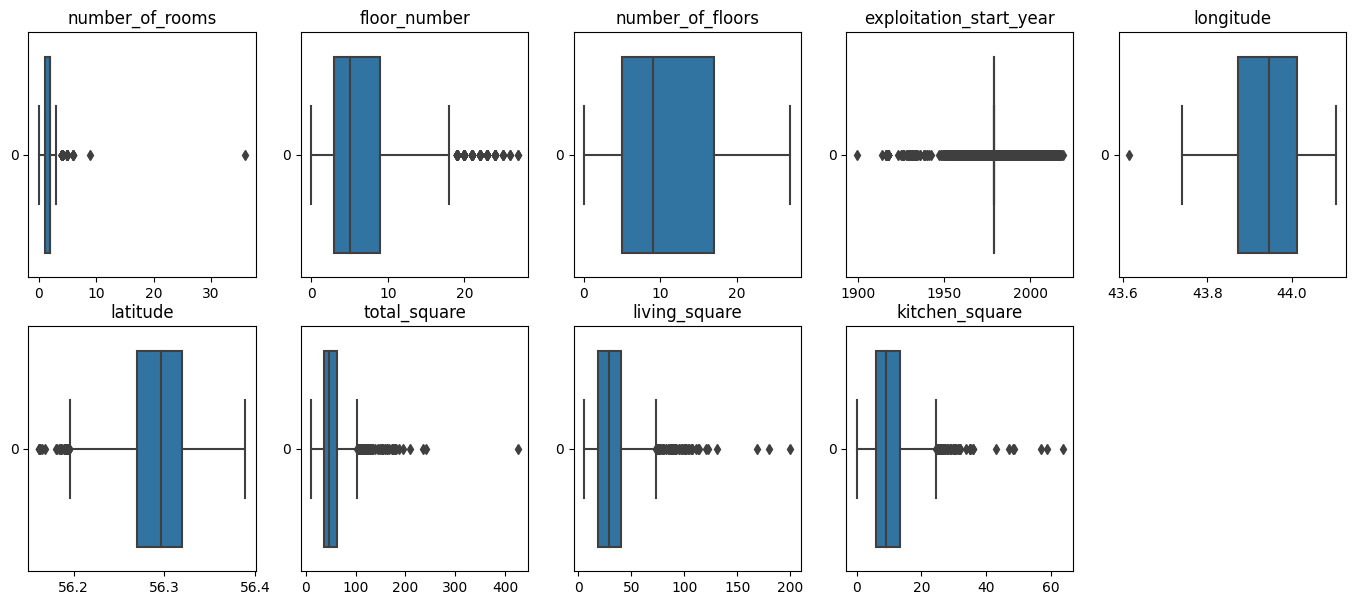

In [70]:
plt.figure(figsize=(17, 7))
for i in list_col2:
  plt.subplot(2, 5, list_col2.index(i) + 1)
  sns.boxplot(test_data[i], orient = 'h').set(title=i)

In [71]:
avg_fn_test = round(test_data['floor_number'].mean(), 0)
test_data['floor_number'] = test_data['floor_number'].apply(lambda x: avg_fn_test if x > 15 else x)
avg_nr_test = round(test_data['number_of_rooms'].mean(), 0)
test_data['number_of_rooms'] = test_data['number_of_rooms'].apply(lambda x: avg_nr_test if x > 5 else x)
avg_exp_year_test = round(test_data['exploitation_start_year'].mean())
test_data['exploitation_start_year'] = test_data['exploitation_start_year'].apply(lambda x: avg_exp_year_test if x < 1960 else x)
total_square_avg = round(test_data['total_square'].mean(), 0)
test_data['total_square'] = test_data['total_square'].apply(lambda x: total_square_avg if x > 100 else x)
avg_living_avg = round(test_data['living_square'].mean(), 0)
test_data['living_square'] = test_data['living_square'].apply(lambda x: avg_living_avg if x > 70 else x)
avg_kitchen_square = round(test_data['kitchen_square'].mean(), 0)
test_data['kitchen_square'] = test_data['kitchen_square'].apply(lambda x: avg_kitchen_square if x > 20 else x)
avg_latitude = test_data['latitude'].mean()
test_data['latitude'] = test_data['latitude'].apply(lambda x: avg_latitude if x < 56.2 else x)
avg_longitude = test_data['longitude'].mean()
test_data['longitude'] = test_data['longitude'].apply(lambda x: avg_longitude if x < 43.65 else x)

In [72]:
test_data.describe()

,id,number_of_rooms,floor_number,number_of_floors,exploitation_start_year,longitude,latitude,total_square,living_square,kitchen_square,created_at
count,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3.719000e+03
mean,584822.083087,1.815004,5.345792,11.741059,1981.148965,43.944082,56.293079,49.552605,30.226629,9.704137,1.686911e+18
std,6807.285916,0.952153,3.506289,6.913506,11.433032,0.079810,0.038026,17.536692,13.346238,3.977279,2.420034e+15
min,573523.000000,0.000000,0.000000,0.000000,1960.000000,43.739834,56.200508,11.100000,5.400000,0.000000,1.680308e+18
25%,578847.500000,1.000000,3.000000,5.000000,1979.000000,43.872303,56.269672,36.200000,18.193000,6.100000,1.685625e+18
50%,584569.000000,2.000000,5.000000,9.000000,1979.000000,43.946859,56.296551,47.000000,28.700000,9.000000,1.686873e+18
75%,590666.500000,2.000000,7.000000,17.000000,1979.000000,44.012010,56.319028,61.000000,39.300000,12.000000,1.688705e+18
max,597149.000000,5.000000,15.000000,27.000000,2019.000000,44.104163,56.389224,100.000000,70.000000,20.000000,1.690847e+18


In [73]:
from sklearn.preprocessing import LabelEncoder
l_encoder = LabelEncoder()

df_train['source'] = l_encoder.fit_transform(df_train['source'])
test_data['source'] = l_encoder.fit_transform(test_data['source'])

<ipython-input-73-ef85d40e614d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['source'] = l_encoder.fit_transform(df_train['source'])


In [74]:
X_long_lat_train = df_train[['latitude','longitude']]
X_long_lat_test = test_data[['latitude','longitude']]

In [75]:
# For train set
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 6)
kmeans.fit(X_long_lat_train)
prediction_k = kmeans.predict(X_long_lat_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [76]:
#For test set
kmeans = KMeans(n_clusters = 6)
kmeans.fit(X_long_lat_test)
prediction_test = kmeans.predict(X_long_lat_test)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


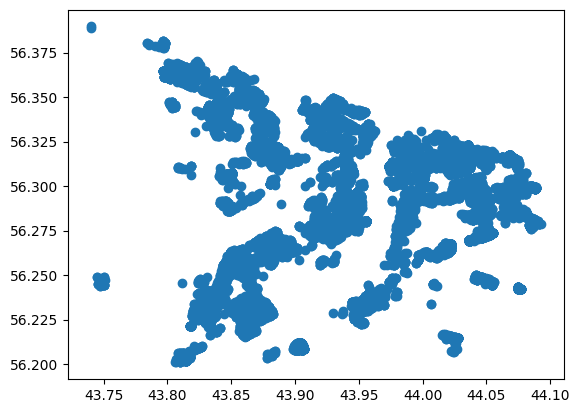

In [81]:
plt.scatter(X_long_lat_train['longitude'], X_long_lat_train['latitude'])
plt.show()

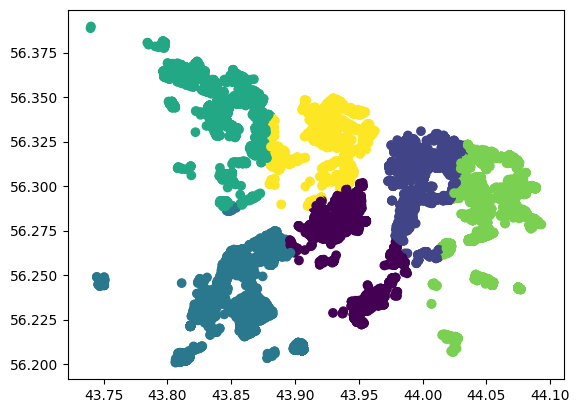

In [82]:
plt.scatter(X_long_lat_train['longitude'], X_long_lat_train['latitude'], c=prediction_k)
plt.show()

In [83]:
df_train['Clusters'] = prediction_k
test_data['Clusters'] = prediction_test

<ipython-input-83-29fc924345b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Clusters'] = prediction_k


In [84]:
X = df_train.drop('price', axis=1)
y = np.log(df_train['price'])

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

#Linear Regression

In [86]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'Score in train set: {model.score(X_train, y_train)}')
print(f'Score in validation set: {model.score(X_val, y_val)}')
print(f'R2 Score: {r2_score(y_val, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_val, y_pred)}')

Score in train set: 0.6579295920644873
Score in validation set: 0.6225063024003639
R2 Score: 0.6225063024003639
MAE score: 0.17030621514125485


#Random Forest Regression

In [115]:
rf = RandomForestRegressor(n_estimators=700, max_depth=20, min_samples_split=10, min_samples_leaf=15, random_state=42)
rf.fit(X_train, y_train)
prediction = rf.predict(X_val)
print(f'Score in train set: {rf.score(X_train, y_train)}')
print(f'Score in validation set: {rf.score(X_val, y_val)}')
print(f'R2 Score: {r2_score(y_val, prediction)}')
print(f'MAE score: {mean_absolute_error(y_val, prediction)}')

Score in train set: 0.8460449613333773
Score in validation set: 0.7649019757679184
R2 Score: 0.7649019757679184
MAE score: 0.09704158580671007


#Let`s identify best parameters for 'Random Forest Regressor' through GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],
    'max_depth': [10, 25, 32]
}
model_rf = RandomForestRegressor(random_state=42)
clf = GridSearchCV(model_rf, param_grid, n_jobs=-1, cv=5)
clf.fit(X, y)
clf.best_params_

#Gradient Boosting Regression

In [118]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=15)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_val)
print(f'Score in train set: {gb.score(X_train, y_train)}')
print(f'Score in validation set: {gb.score(X_val, y_val)}')
print(f'R2 Score: {r2_score(y_val, gb_pred)}')
print(f'MAE score: {mean_absolute_error(y_val, gb_pred)}')

Score in train set: 0.9999992050380685
Score in validation set: 0.7051970174375927
R2 Score: 0.7051970174375927
MAE score: 0.08805976568978831


#Cat Boost Regression

In [119]:
сatb = CatBoostRegressor(iterations=100)
сatb.fit(X_train, y_train)
pred_cat = сatb.predict(X_val)
print(f'Score in train set:{сatb.score(X_train, y_train)}')
print(f'Score in validation set:{сatb.score(X_val, y_val)}')
print(f'R2 Score: {r2_score(y_val, pred_cat)}')
print(f'MAE score: {mean_absolute_error(y_val, pred_cat)}')

Learning rate set to 0.380821
0:	learn: 0.3543004	total: 52.1ms	remaining: 5.15s
1:	learn: 0.2987841	total: 55.8ms	remaining: 2.73s
2:	learn: 0.2603723	total: 59.8ms	remaining: 1.93s
3:	learn: 0.2416345	total: 63.4ms	remaining: 1.52s
4:	learn: 0.2287678	total: 67.1ms	remaining: 1.27s
5:	learn: 0.2218479	total: 70.9ms	remaining: 1.11s
6:	learn: 0.2160489	total: 74.6ms	remaining: 991ms
7:	learn: 0.2118429	total: 78.1ms	remaining: 898ms
8:	learn: 0.2097034	total: 84.3ms	remaining: 853ms
9:	learn: 0.2079149	total: 88.4ms	remaining: 796ms
10:	learn: 0.2058172	total: 92.1ms	remaining: 745ms
11:	learn: 0.2040569	total: 95.7ms	remaining: 702ms
12:	learn: 0.2025130	total: 99.3ms	remaining: 664ms
13:	learn: 0.2011419	total: 103ms	remaining: 632ms
14:	learn: 0.2003511	total: 106ms	remaining: 603ms
15:	learn: 0.1981514	total: 110ms	remaining: 578ms
16:	learn: 0.1971834	total: 114ms	remaining: 555ms
17:	learn: 0.1961869	total: 117ms	remaining: 535ms
18:	learn: 0.1947140	total: 121ms	remaining: 515m

In [129]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators = 200, max_depth=10, reg_lambda=12, reg_alpha=12)
xgb.fit(X_train, y_train)
pred_x = xgb.predict(X_val)
print(f'Score in train set: {xgb.score(X_train, y_train)}')
print(f'Score in validation set: {xgb.score(X_val, y_val)}')
print(f'R2 score: {r2_score(y_val, pred_x)}')
print(f'MAE score: {mean_absolute_error(y_val, pred_x)}')

Score in train set: 0.8425505508700399
Score in validation set: 0.7651600348250903
R2 score: 0.7651600348250903
MAE score: 0.09995777798374741


In [127]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [10, 15, 20]
}
model_xgb = XGBRegressor(random_state=32)
clf2 = GridSearchCV(model_xgb, param_grid, n_jobs=-1, cv=5)
clf2.fit(X, y)
clf2.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [128]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_estimators= 150)
lgb.fit(X_train, y_train)
pred_lgb = lgb.predict(X_val)
print(f'Score in train set: {lgb.score(X_train, y_train)}')
print(f'Score in validation set: {lgb.score(X_val, y_val)}')
print(f'R2 score: {r2_score(y_val, pred_lgb)}')
print(f'MAE score: {mean_absolute_error(y_val, pred_lgb)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1883
[LightGBM] [Info] Number of data points in the train set: 9648, number of used features: 13
[LightGBM] [Info] Start training from score 15.566769
Score in train set: 0.9037707813685358
Score in validation set: 0.7677327125221262
R2 score: 0.7677327125221262
MAE score: 0.0946646094496141


In [131]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(n_estimators=50)
ada.fit(X_train, y_train)
pred_ada = ada.predict(X_val)
print(f'Score in train set: {ada.score(X_train, y_train)}')
print(f'Score in validation set: {ada.score(X_val, y_val)}')
print(f'R2 score: {r2_score(y_val, pred_ada)}')
print(f'MAE score: {mean_absolute_error(y_val, pred_ada)}')

Score in train set: 0.4983800254714177
Score in validation set: 0.3385820941431269
R2 score: 0.3385820941431269
MAE score: 0.25327598127680867


#After analyzing and predicting our target in different type of algorithms the best score was obtained by RandomForestRegressor.

In [89]:
#Let`s now predict our 'price' by using the hole dataset
rf = RandomForestRegressor(n_estimators=700, max_depth=20, max_features='log2', min_samples_split=10, min_samples_leaf=15, random_state=42)
rf.fit(X, y)
rf_prediction = rf.predict(test_data)

In [125]:
final_prediction = np.exp(rf_prediction)

In [126]:
def submission(prediction):
  submission = pd.DataFrame()
  submission['id'] = test_data['id']
  submission['price'] = prediction
  submission.to_csv('Ml_project.csv', index=False, sep=',')

In [124]:
submission(final_prediction)